# Exercise 1: Gibbs sampling

In [1]:
# ------------ MAIN LIBRARIES TO USE ------------ 

using CSV, DataFrames
using Plots
using Distributions, Statistics
using Optim, NLopt
using LinearAlgebra
import Random

Random.seed!(14052021)

MersenneTwister(14052021)

## Settlement

I thought it could be interesting to compare how the population of two different countries is distributed. The two countries that I have chosen are respectively **Japan and Russia**. Why these two? Well, for starters, it could be nice to see how the Pareto Law is met in two countries that have considerable differences:

1. Japan is about 45 times smaller than Russia. Russia is approximately 17,098,242 km$^2$, while Japan is approximately 377,915 km$^2$, making Japan 2.21% the size of Russia.

2. Interestingly, Russia is one of the most sparsely populated countries in the world, in part due to its harsh climate. The country has a population density of just 8.4 people per km$^2$. The population density in Japan is 347 people per km$^2$.

We see huge differences,  indeed. Nevertheless, the population in Russia is most dense in the European area of the country around Saint Petersburg and Moscow. So let's see if the population in these two different countries is similarly distributed.


## Quick reminder (theory behind the code, can be jumped)

The Pareto distribution:

$$\text{Pareto}(x|\alpha,c)=\frac{\alpha c^{\alpha}}{x^{\alpha + 1}}$$

which is basically a power law distribution. The two parameters are $c$, the (necessarily positive) minimum possible value of $X$ - the city with the smallest population, and $\alpha$, often called the Pareto index if we are dealing with the wealth of people, represents the proportion or the scaling relationship. In our case, the **prior** will be:

$$p(\alpha,c)\propto \mathbb{1}(x>c)$$

Using Bayes' theorem we define the **posterior** to be proportional to the likelihood times the prior:

$$p(\alpha,c|x_{1:n})\propto p(x_{1:n}|\alpha,c)p(\alpha,c)\propto \mathbb{1}(\alpha,c>0)\prod_{i=1}^{n}\frac{\alpha c^{\alpha}}{x_i^{\alpha+1}}\mathbb{1}(x_i>c)=\frac{\alpha^{n}c^{n\alpha}}{(\prod x_i)^{\alpha+1}}\mathbb{1}(c<x*)\mathbb{1}(\alpha,c>0)$$

To use Gibbs, we need to be able to sample $\alpha|x_{1:n}$ and $c|x_{1:n}$. We need both posteriors. From the equation above:

$$p(\alpha|c,x_{1:n})\propto \frac{\alpha^{n}c^{n\alpha}}{(\prod x_i)^{\alpha}}\mathbb{1}(\alpha>0)=\alpha^{n}\text{exp}\left(-\alpha\left(\sum \text{log}\,x_i-n\,\text{log}\,c\right)\right)\mathbb{1}(\alpha>0)\\
\propto \text{Gamma} \,\left(\alpha|n+1,\sum \text{log}\,x_i-n\,\text{log}\,c\right)$$

and:

$$p(c|\alpha, x_{1:n})\propto c^{n\alpha}\mathbb{1}(0<c<x*)$$

## Sampling of $\alpha$ and $c$

So, in order to use the Gibbs sampling algorithm to sample from the posterior $p(\alpha,c|x_{1:n})$,we initialize $\alpha$ and $c$, and then alternately update them by sampling:

$$\alpha|c,x_{1:n}\sim \text{Gamma}\,\left(n+1,\sum \text{log}\,x_i-n\,\text{log}\,c\right)$$

$$c|\alpha,x_{1:n}\sim \text{Mono}\,(n\alpha+1,x*)$$

## (1.a) Data collection from a dataset

**Note**: I will take the 170 most populated cities of each countries. This is nothing but a sampling strategy, and a common explanation to it is that small cities are often indistinguishable from rural areas and as a result they can be omitted from the sample selection (Brakman et al., 1999).

In [2]:
# ------- DATA COLLECTION FROM DATASET: Population of 2 countries -----------

df = DataFrame(CSV.File("worldcities.csv"))
hiriak = df.country                          # Read the countries in dataset

# Data from Country 1
bai1 = (hiriak.=="Japan")                    # Choose Country1 to analyse
population1 = df.population[bai1]
cities1 = df.city[bai1]

# Data from Country 2
bai2 = (hiriak.=="Russia")                    # Choose Country2 to analyse
population2 = df.population[bai2]
cities2 = df.city[bai2]

df1 = DataFrame(Cities =cities1,Population=population1)  # Construct the dataframe out of the data
data1 = convert(Matrix, df1);
datuak1 = data1[5:170,2];
df2 = DataFrame(Cities =cities2,Population=population2)  # Construct the dataframe out of the data
data2 = convert(Matrix, df2);
datuak2 = data2[5:170,2];

histogram([datuak1,datuak2], bins=20, alpha=0.8,label=["Japan" "Russia"], title="Histogram population by cities")

## (1.b) Estimate the posterior distribuiton of $\alpha$ and $c$. Show the plot of the distributions. 

In [4]:
# ---------- MAIN FUNCTIONS --------------

function Gibbs(reps::Int, burnin::Int,data)
    chain = fill(NaN, (reps,2))
    alpha   = 1.
    c   = 100.
    n_data = size(data,1)
    x_star = minimum(data)
    for i = 1:reps
        for j = 1:burnin
            alpha = rand(Gamma(n_data+1,1.0./(sum(log.(data))-n_data*log(c))))
            c = x_star*rand(Uniform(0,1))^(1/(n_data*alpha+1))
        end
        chain[i,:] = [alpha,c]     # Construct
    end
    return chain
end
    
# Monomial Distribution
function Monomial(a,x_star,n_data)
    ran = range(0,x_star,length=1000)
    c = zeros(size(ran,1))
    c = ran.^(a*n_data)
end    
        

Monomial (generic function with 1 method)

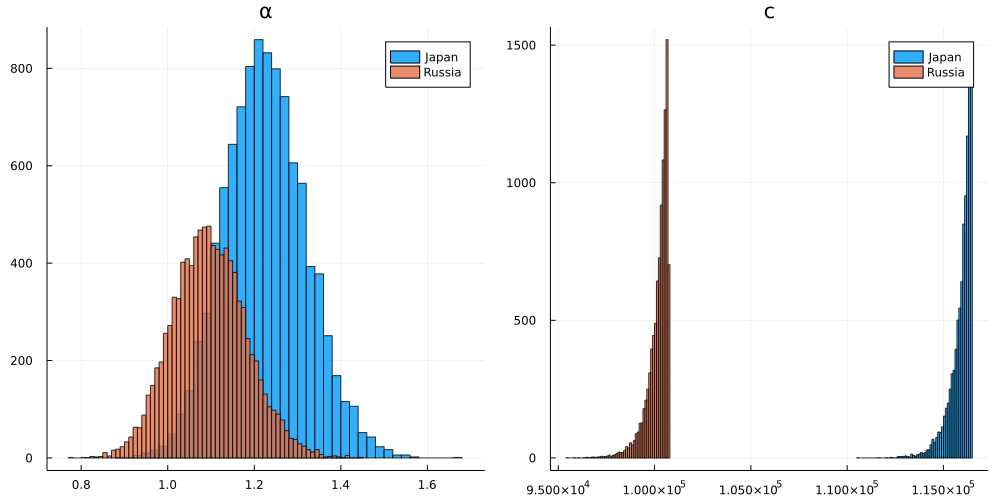

In [5]:
# Compute Gibbs Sampling and Plot 
chain1 = Gibbs(10000,100,datuak1);
chain2 = Gibbs(10000,100,datuak2);
plot([chain1, chain2],layout=2,alpha=0.8,seriestype=[:histogram],label=["Japan" "Japan" "Russia" "Russia"],title=["α" "c"],size=(1000,500))

## (1.c) Calculate the mean of the $\alpha$ and $c$ as you increase the iteration size.

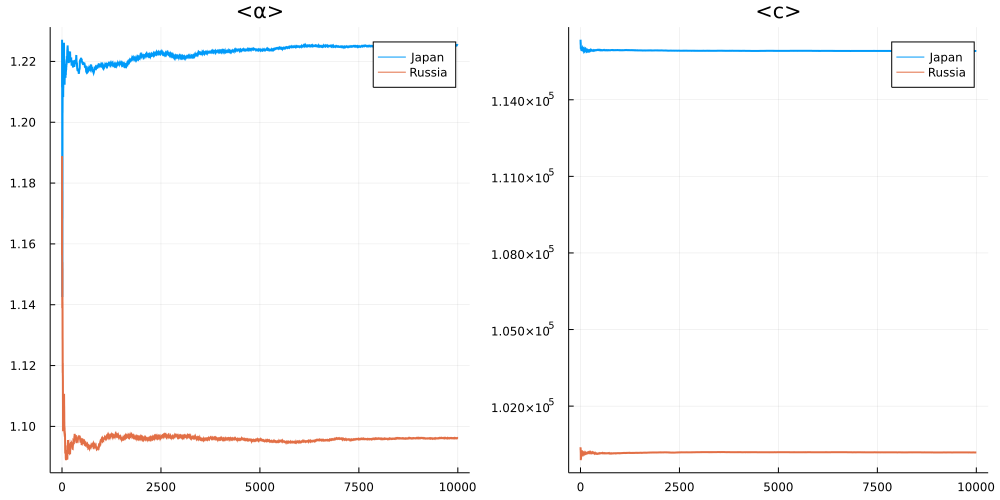

In [6]:
# Country 1
n1 = size(chain1,1)
m1 = zeros(n1,2)
for i=1:n1
    m1[i,:] = mean(chain1[1:i,:],dims=1);
end

# Country 2
n2 = size(chain2,1)
m2 = zeros(n2,2)
for i=1:n2
    m2[i,:] = mean(chain2[1:i,:],dims=1);
end

plot([m1,m2],layout=2,lw=2,title=["<α>" "<c>"],label=["Japan" "Japan" "Russia" "Russia"],size=(1000,500))

## (1.d) Given the estimated $\alpha$ and $c$, generate data using Pareto(x|$\alpha$,c). Plot the distribution.

We take first the converged values of $\alpha$ and $c$.

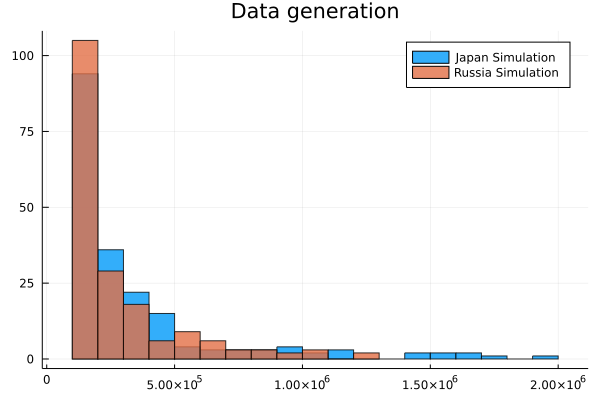

In [7]:
reps=200;

# ---- Country 1 ------
alpha1  = m1[end,1];
c1 = m1[end,2];
chain_trial1 = fill(NaN, (reps,1))
max_val1 = maximum(datuak1)
for i=1:reps
    chain_trial1[i] = rand(Pareto(alpha1,c1))    # Create Pareto sampling distribution from converged \alpha, c
end

# ----- Country 2 ------
alpha2  = m2[end,1];
c2 = m2[end,2];
chain_trial2 = fill(NaN, (reps,1))
max_val2 = maximum(datuak2)
for i=1:reps
    chain_trial2[i] = rand(Pareto(alpha2,c2))   # Create Pareto sampling distribution from converged \alpha, c
end

# PLOT
histogram([chain_trial1[chain_trial1.<maximum(datuak1)],chain_trial2[chain_trial2.<maximum(datuak2)]],bins=20,alpha=0.8,title="Data generation",label=["Japan Simulation" "Russia Simulation"])   # We focus our attention on the data

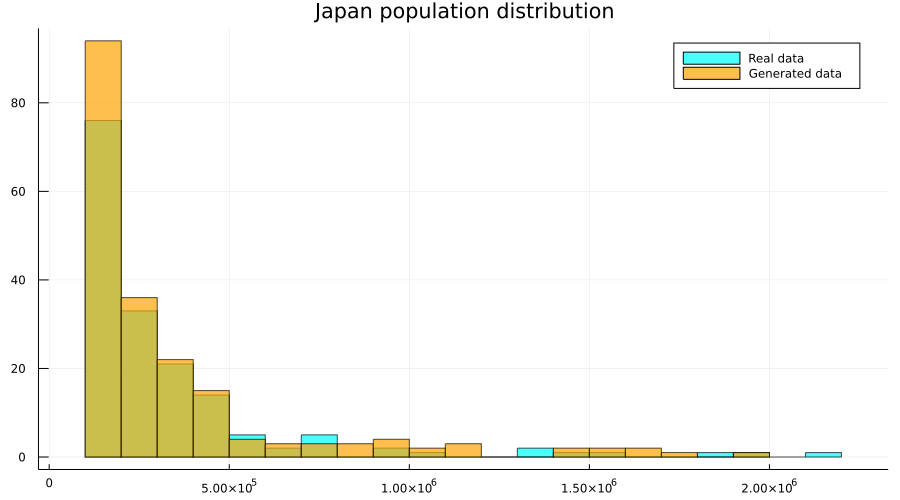

In [8]:
histogram([datuak1,chain_trial1[chain_trial1.<maximum(datuak1)]],layout=1,bins=30,alpha=0.7,color= [:cyan :orange],size=(900,500),title="Japan population distribution",label=["Real data" "Generated data"] )   # We focus our attention on the data

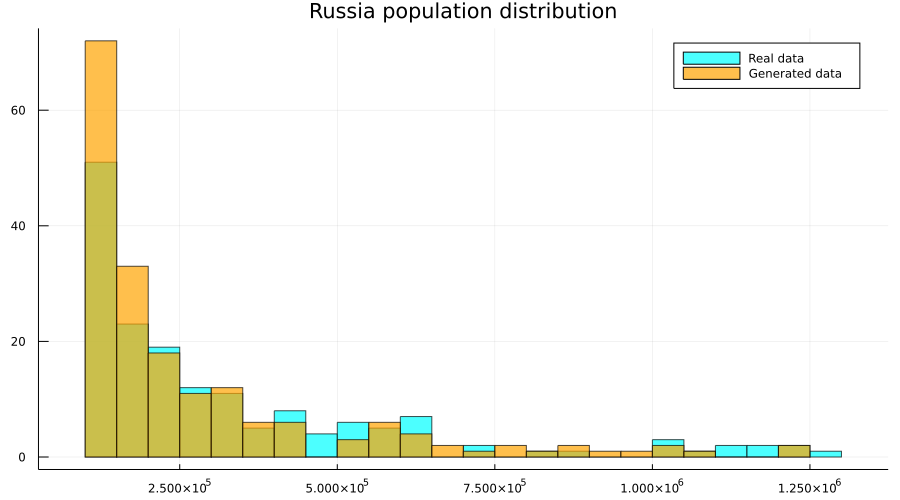

In [9]:
histogram([datuak2,chain_trial2[chain_trial2.<maximum(datuak2)]],layout=1,bins=30,alpha=0.7,color= [:cyan :orange],size=(900,500),title="Russia population distribution",label=["Real data" "Generated data"] )   # We focus our attention on the data

## Conclusions

The size distribution of cities and the evolution of urban systems have been long-standing topics of research in urban studies, and we can appreaciate why computing the Pareto distribution of a specific country could be interesting: in this Problem Set, even if we analyse very distinct countries in many aspects (demography, geography, topography, total population, culture, history, etc.), Pareto Laws are observable. How the population is distributed in cities is, at least, a comparable characteristic between Japan and Russia (here we are interested on the shape of the distribution). What these Pareto Laws could foresee, however, is out of the scope of this  project. 

# Exercise 2

Examining historical stock price of Google.

In [10]:
# ------------- MAIN FUNCTIONS TO USE --------------------

function fmincon(obj, startval, R=[], r=[], lb=[], ub=[]; tol = 1e-10, iterlim=0)
    # the objective is an anonymous function
    function objective_function(x::Vector{Float64}, grad::Vector{Float64})
        obj_func_value = obj(x)[1,1]
        return(obj_func_value)
    end
    # impose the linear restrictions
    function constraint_function(x::Vector, grad::Vector, R, r)
        result = R*x .- r
        return result[1,1]
    end
    opt = Opt(:LN_COBYLA, size(startval,1))
    min_objective!(opt, objective_function)
    # impose lower and/or upper bounds
    if lb != [] lower_bounds!(opt, lb) end
    if ub != [] upper_bounds!(opt, ub) end
    # impose linear restrictions, by looping over the rows
    if R != []
        for i = 1:size(R,1)
            equality_constraint!(opt, (theta, g) -> constraint_function(theta, g, R[i:i,:], r[i]), tol)
        end
    end    
    xtol_rel!(opt, tol)
    ftol_rel!(opt, tol)
    maxeval!(opt, iterlim)
    (objvalue, xopt, flag) = NLopt.optimize(opt, startval)
    return xopt, objvalue, flag
end

fmincon (generic function with 5 methods)

In [16]:
# --------------- DATASET ---------------

data = DataFrame(CSV.File("GOOG.csv",header=true))
first(data,6)
y = data[!,"Adj Close"];               # Take closing price
y = 100.0*diff(log.(y));               # Compute log-returns
n = size(y,1);
last(data,7)

,Date,Open,High,Low,Close,Adj Close,Volume
,Date,Float64,Float64,Float64,Float64,Float64,Int64
1,2021-05-04,2369.74,2379.26,2311.7,2354.25,2354.25,1756000
2,2021-05-05,2368.42,2382.2,2351.41,2356.74,2356.74,1090300
3,2021-05-06,2350.64,2382.71,2342.34,2381.35,2381.35,1030900
4,2021-05-07,2400.0,2416.41,2390.0,2398.69,2398.69,1163600
5,2021-05-10,2374.89,2378.0,2334.73,2341.66,2341.66,1300300
6,2021-05-11,2291.86,2322.0,2283.0,2308.76,2308.76,1603300
7,2021-05-12,2261.71,2285.37,2235.01,2244.89,2244.89,847188


## (2.a) Estimate the following models: GARCH(1,1); GARCH(1,2); GARCH(2,1); and GARCH(2,2) of the adjusted closing price.

### Garch(p,q) functions

In [21]:
# ----- GARCH (1,1) --------
function garch11(theta, y)
    # dissect the parameter vector
    mu = theta[1]
    rho = theta[2]
    omega = theta[3]
    alpha = theta[4]
    beta = theta[5]
    resid = y[2:end] .- mu .- rho*y[1:end-1]
    n = size(resid,1)
    h = zeros(n)
    # initialize variance; either of these next two are reasonable choices
    h[1] = var(y)
    #h[1] = var(y)
    rsq = resid.^2.0
    for t = 2:n
        h[t] = omega + alpha*rsq[t-1] + beta*h[t-1]
    end
    logL = -log(sqrt(2.0*pi)) .- 0.5*log.(h) .- 0.5*rsq./h    # h = \sigma^2
end
# ----- GARCH (1,2) --------
function garch12(theta, y)
    # dissect the parameter vector
    mu = theta[1]
    rho = theta[2]
    omega = theta[3]
    alpha1 = theta[4]
    alpha2 = theta[5]
    beta1 = theta[6]
    resid = y[2:end] .- mu .- rho*y[1:end-1]
    n = size(resid,1)
    h = zeros(n)
    # initialize variance; either of these next two are reasonable choices
    h[1] = var(y)
    h[2] = var(y)
    #h[2] = omega + alpha1*rsq[1] + beta1*h[1]
    #h[1] = var(y)
    rsq = resid.^2.0
    for t = 3:n
        h[t] = omega + alpha1*rsq[t-1] + alpha2*rsq[t-2] + beta1*h[t-1]
    end
    logL = -log(sqrt(2.0*pi)) .- 0.5*log.(h) .- 0.5*rsq./h    # h = \sigma^2
end
# ----- GARCH (2,1) --------
function garch21(theta, y)
    # dissect the parameter vector
    mu = theta[1]
    rho = theta[2]
    omega = theta[3]
    alpha1 = theta[4]
    beta1 = theta[5]
    beta2 = theta[6]
    resid = y[2:end] .- mu .- rho*y[1:end-1]
    n = size(resid,1)
    h = zeros(n)
    # initialize variance; either of these next two are reasonable choices
    h[1] = var(y)
    #h[2] = omega + alpha1*rsq[1] + beta1*h[1]
    h[2] = var(y)
    rsq = resid.^2.0
    for t = 3:n
        h[t] = omega + alpha1*rsq[t-1] + beta1*h[t-1] + beta2*h[t-2]
    end
    logL = -log(sqrt(2.0*pi)) .- 0.5*log.(h) .- 0.5*rsq./h    # h = \sigma^2
end
# ----- GARCH (2,2) --------
function garch22(theta, y)
    # dissect the parameter vector
    mu = theta[1]
    rho = theta[2]
    omega = theta[3]
    alpha1 = theta[4]
    alpha2 = theta[5]
    beta1 = theta[6]
    beta2 = theta[7]
    resid = y[2:end] .- mu .- rho*y[1:end-1]
    n = size(resid,1)
    h = zeros(n)
    # initialize variance; either of these next two are reasonable choices
    h[1] = var(y)
    #h[2] = omega + alpha1*rsq[1] + beta1*h[1]
    h[2] = var(y)
    rsq = resid.^2.0
    for t = 3:n
        h[t] = omega + alpha1*rsq[t-1] + alpha2*rsq[t-2] + beta1*h[t-1] + beta2*h[t-2]
    end
    logL = -log(sqrt(2.0*pi)) .- 0.5*log.(h) .- 0.5*rsq./h    # h = \sigma^2
end

garch22 (generic function with 1 method)

In [18]:
# ----- GARCH (1,1) --------
thetastart11 = [mean(y); 0.0; var(y); 0.1; 0.1]
obj = theta -> -sum(garch11(theta, y))
thetahat11, logL11, junk  = fmincon(obj, thetastart11, [], [], [-Inf, -1.0, 0.0, 0.0, 0.0], [Inf, 1.0, Inf, 1.0, 1.0])
thetahat11 = [thetahat11[1:4]; NaN; thetahat11[5]; NaN]
# ----- GARCH (1,2) --------
thetastart12 = [mean(y); 0.0; var(y); 0.1; 0.1; 0.1]
obj = theta -> -sum(garch12(theta, y))
thetahat12, logL12, junk  = fmincon(obj, thetastart12, [], [], [-Inf, -1.0, 0.0, 0.0, 0.0, 0.0], [Inf, 1.0, Inf, 1.0, 1.0, 1.0])
thetahat12 = [thetahat12; NaN]
# ----- GARCH (2,1) --------
thetastart21 = [mean(y); 0.0; var(y); 0.1; 0.1; 0.1]
obj = theta -> -sum(garch21(theta, y))
thetahat21, logL21, junk  = fmincon(obj, thetastart21, [], [], [-Inf, -1.0, 0.0, 0.0, 0.0, 0.0], [Inf, 1.0, Inf, 1.0, 1.0, 1.0])
thetahat21 = [thetahat21[1:4];NaN;thetahat21[5:end]]
# ----- GARCH (2,2) --------
thetastart22 = [mean(y); 0.0; var(y); 0.1; 0.1; 0.1; 0.1]
obj = theta -> -sum(garch22(theta, y))
thetahat22, logL22, junk  = fmincon(obj, thetastart22, [], [], [-Inf, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [Inf, 1.0, Inf, 1.0, 1.0, 1.0, 1.0])

df = DataFrame(Garch11=thetahat11, Garch12=thetahat12, Garch21=thetahat21, Garch22=thetahat22)

,Garch11,Garch12,Garch21,Garch22
,Float64,Float64,Float64,Float64
1,0.140994,0.154685,0.140364,0.15666
2,-0.0651047,-0.0625597,-0.0648475,-0.0619131
3,0.851438,1.07594,0.865024,1.23001
4,0.136657,0.0990965,0.135225,0.0968289
5,NaN,0.0727597,NaN,0.098626
6,0.606273,0.50403,0.603706,0.338286
7,NaN,NaN,6.66914e-24,0.0955641


The numbers correspond to: 1 = $\hat\mu$ ; 2 = $\hat\rho$ ; 3 = $\hat\omega$ ; 4 = $\hat\alpha_{1}$ ; 5 = $\hat\alpha_{2}$ ; 6 = $\hat\beta_{1}$ ; 7 = $\hat\beta_{2}$

## (2.b) Calculate AIC for all four models above.

The formulation I have used:

$$\text{AIC} = 2k-2\,\text{ln}(L)$$

Where $k$ is the number of parameters of our model (level of _complexity_ of the model) and ln$(L)$ is the log likelihood (how well our model performs). We seek for a model that is able to explain the most in the simplest way, and due to this tradeoff, one should choose the model that yields the lowest AIC.

In [19]:
AIC = zeros(4)
AIC[1] = -2*logL11 + 2*5;
AIC[2] = -2*logL12 + 2*6;
AIC[3] = -2*logL21 + 2*6;
AIC[4] = -2*logL22 + 2*7;
df = DataFrame(Models = ["Garch(1,1)", "Garch(1,2)", "Garch(2,1)", "Garch(2,2)"], AIC_Value=AIC)

,Models,AIC_Value
,String,Float64
1,"Garch(1,1)",-985.265
2,"Garch(1,2)",-983.021
3,"Garch(2,1)",-983.464
4,"Garch(2,2)",-980.907


## (2.c) Calculate BIC for all four models above.

$$\text{BIC}=\text{ln}\,(n)k-2\,\text{ln}\,(L)$$

Where, as before, $k$ is the number of parameters of our model (level of _complexity_ of the model) and ln$(L)$ is the log likelihood (how well our model performs). 

In [20]:
BIC = zeros(4)
BIC[1] = -2*logL11 + log(n)*5;
BIC[2] = -2*logL12 + log(n)*6;
BIC[3] = -2*logL21 + log(n)*6;
BIC[4] = -2*logL22 + log(n)*7;
df = DataFrame(Models = ["Garch(1,1)", "Garch(1,2)", "Garch(2,1)", "Garch(2,2)"], BIC_Value=BIC)

,Models,BIC_Value
,String,Float64
1,"Garch(1,1)",-967.618
2,"Garch(1,2)",-961.845
3,"Garch(2,1)",-962.288
4,"Garch(2,2)",-956.201


## (2.d) Choose the optimal model (i.e., choose the combination of (p,q) that maximizes either AIC or BIC) and explain your result.

The  volatility  of  Google  returns  has  been  modelled  for  a  period  of  2020-05-12  to  2021-05-12  using  different  GARCH(p,q) models; GARCH(1,1), GARCH(1,2), GARCH(2,1) and GARCH(2,2).

Overall, GARCH(1,1) outperformed the other models as observed from the smallest AIC and BIC values: it gives the optimal tradeoff between complexity and accuracy. Put it simply, it can describe almost as much as the others but without the need of more than one lag.

Therefore, we see that a GARCH (1,1) model has satisfactory statistical properties to capture volatility in the data when analysing stock returs. 